## Noisier CRC

> By Utaha
> 
> I made a serious mistake last time. Now it won't be that easy!
> 
> `nc chals.sekai.team 3006`
> 
> Attachment: chall.py

We have a similar setup to Noisy CRC, but now

1. There are 12 extra random CRCs instead of 2 extra, for a total of 13 candidates per modulus.
2. We must query with irreducible moduli, preventing us from using the "integrity check" strategy from earlier.
3. Only 133 moduli can be queried.

To start with, since we can't do much about the irreducible check just send 133 irreducible polynomials and obtain the noisy CRCs.

In [1]:
from pwn import *
from tqdm.auto import tqdm

# context.log_level = "debug"

Fn = GF(2)
Rn.<x> = PolynomialRing(Fn)

LOCAL = False
r = remote("chals.sekai.team", int(3006))

# # Local instance with side channel leak for sanity checking
# LOCAL = True
# r = process(["python", "noisiercrc-localrun.py"])

r.recvuntil(b"flag: ")
flag_enc = r.recvline().strip().decode()

def oracle_send(x): # helper to query with polynomial
    x = ZZ(list(x.change_ring(ZZ)), 2)
    r.sendline(f"{x}".encode())

def oracle_recv(): # helper to return polynomial
    r.recvuntil(b"ial: ")
    crcs = safeeval.expr(r.recvline())
    crcs = [ Rn(ZZ(crc).bits()) for crc in crcs ]
    return crcs

# Query 100 sets of g(x) * h_i(x)
n = 133

queries = []
while len(queries) < n:
    query = Rn.irreducible_element(16, algorithm="random")
    # In case irreducible_element collides
    if query not in queries:
        queries.append(query)
        oracle_send(query)

results = []
for _ in tqdm(range(n)):
    results.append(oracle_recv())

r.close()

[x] Opening connection to chals.sekai.team on port 3006
[x] Opening connection to chals.sekai.team on port 3006: Trying 34.148.151.228
[+] Opening connection to chals.sekai.team on port 3006: Done


  0%|          | 0/133 [00:00<?, ?it/s]

[*] Closed connection to chals.sekai.team port 3006


Theoretically, combining the correct CRC samples with CRT will produce a short 528-degree polynomial despite 2128-degree modulus. Since CRT is a linear combination of remainders, we can try to transform all of the noisy CRCs into the values it would have contributed if it were included in CRT. We obtain 1729 different 2128-degree polynomials in $F_2$[^1], where the sum of the correct 133 polynomials should only be degree 528.

[^1]: 133 samples * 13 noisy CRCs = 1729 polynomials, 133 samples * 16 degree per moduli = 2128 degree of combined product.

In [2]:
full_modulus = product(queries)
noisy_polynomials = []
for crc_mod, crc_remainders in zip(queries, results):
    full_modulus_less_crc_mod = Rn(full_modulus // crc_mod)
    for crc_remainder in crc_remainders:
        noisy_polynomials.append(CRT(crc_remainder, 0, crc_mod, full_modulus_less_crc_mod))

if LOCAL:
    # Sanity check if running locally
    import json
    with open("noisiercrc-localrun-leak.json") as f:
        leak_data = json.load(f)
    leak_correct_polynomials = [idx * 13 + x for idx, x in enumerate(leak_data["correct_positions"])]
    leak_sum_of_correct_polynomials = sum([noisy_polynomials[i] for i in leak_correct_polynomials])
    assert leak_sum_of_correct_polynomials.degree() < 528

We know the secret should only have coefficients between $x^{16}$ and $x^{527}$, so we know that all other coefficents of the sum of valid CRCs should eventually be 0. This turns into a system of 1616 equations with 1729 unknowns. We have more unknowns than relationships, so there will be multiple solutions, to be exact up to $2^{1729-1616} = 2^{133}$ of them. These solutions lie in the lattice formed by basis vectors of the right kernel of a matrix derived from the coefficients.

  0%|          | 0/1729 [00:00<?, ?it/s]

113 x 1729 dense matrix over Finite Field of size 2


<Axes: >

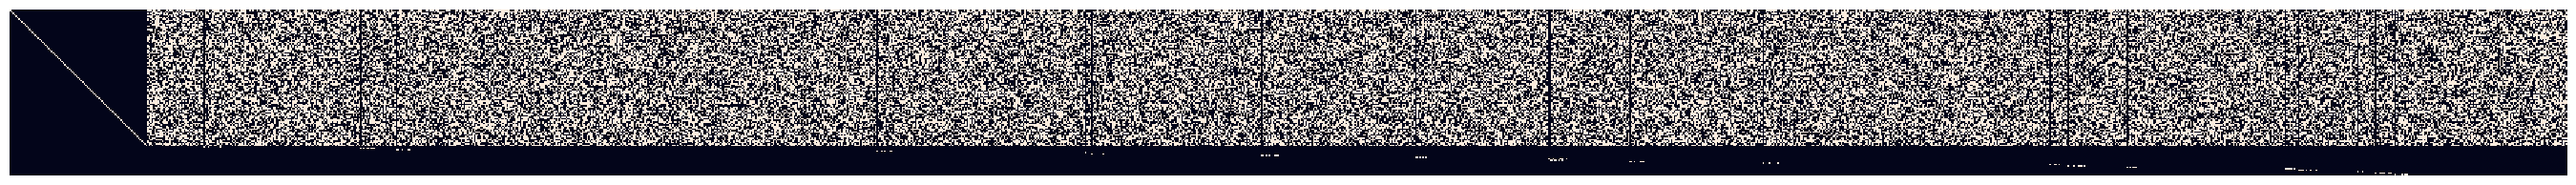

In [3]:
n_coeffs = full_modulus.degree()

coeff_matrix = []
for noisy_polynomial in tqdm(noisy_polynomials):
    noisy_coeffs = list(noisy_polynomial)
    noisy_coeffs += [0] * (n_coeffs - len(noisy_coeffs))
    coeff_matrix.append(noisy_coeffs)

# One column = one polynomial, one row = one coefficient
coeff_matrix = Matrix(Fn, coeff_matrix).transpose()

force_zero_indices = list(range(0, 16)) + list(range(16 + 512, n_coeffs))
force_zero_goal = vector([0] * len(force_zero_indices))
basis = coeff_matrix[force_zero_indices].right_kernel().basis()
basis_mat = Matrix(basis)
print(repr(basis_mat))

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(1729 / 50, 113 / 50))
sns.heatmap(
    Matrix(basis).numpy().astype(int),
    xticklabels=False,
    yticklabels=False,
    cbar=False
)

Fortunately, we don't need to iterate through all $2^113$ possibilities. We know that the true combination of CRCs only involve 1 in every 13 noisy CRCs, and this corresponds to some linear combination of the basis vectors which has a low (but non-zero) hamming weight.

We can use this restriction to prune the search. See the nice diagonal of the basis lattice? If we guess the first 7-8 true CRCs from groups of 13 noisy CRCs, we can use the sum of the correspoding basis vectors in the diagnoal part of the basis to fix these bits. If any other rows have high hamming weight but are not included in the diagonal, brute force the addition of all subsets of them. If any resultant combination has a low hamming weight, this is a possible solution.

In [4]:
n_ident = None
for d in range(80, 112):
    if basis_mat[:d, :d] == Matrix.identity(d):
        n_ident = d
print(f"{n_ident=}")

basis_mat_colsum = sum(basis_mat.change_ring(ZZ).columns())
highweights = []
for d in range(n_ident, 112):
    if basis_mat_colsum[d] > 40:
        highweights.append(d)
print(f"{highweights=}")

n_fix = n_ident // 13
n_tail = ZZ(n_ident % 13)

estimated_bruteforce = 13^n_fix * (n_tail + 1) * 2^len(highweights)
print(f"{estimated_bruteforce=} ({estimated_bruteforce.nbits()} bit)")

n_ident=93
highweights=[]
estimated_bruteforce=188245551 (28 bit)


In [5]:
from gmpy2 import mpz
import itertools
from multiprocessing import Pool

basis_mpz = [
    mpz("".join([str(i) for i in basis_row][::-1]), 2) 
    for basis_row in basis
]

fix_groups = []
for fix_group_i in range(n_fix):
    fix_group = basis_mpz[13*fix_group_i:13*(fix_group_i+1)]
    fix_groups.append(fix_group)

tail_group = [mpz(0)] + basis_mpz[13*n_fix:13*n_fix+n_tail]

highweight_group = [mpz(0)]
for highweight_row in highweights:
    highweight_group = highweight_group + [
        x ^^ basis_mpz[highweight_row]
        for x in highweight_group
    ]

def xor_hamming_weight(x):
    a = mpz(int(0))
    for i in x:
        a = a ^^ i
    res = bin(a).count("1")
    if res < 400:
        return res, x
    else:
        return None

search_space = fix_groups + [tail_group, highweight_group]

found_solns = []
with Pool(16) as pool:
    for res in tqdm(
        pool.imap_unordered(xor_hamming_weight, itertools.product(*search_space), chunksize=100000),
        total=int(estimated_bruteforce)
    ):
        if res is None:
            continue
        print(res)
        found_solns.append(res[1])

  0%|          | 0/188245551 [00:00<?, ?it/s]

(134, (mpz(16828910562050779542407309470146743777488612357220195831066575244159932586722212008244314576992479438496242274387367515538828030044461665679708774063888876858690209619933820440946354008148064210481437388328859385214167068410032239385769589121835650028803380076360586162476709578892308303385186817339272771702765524069760827515879194807104700496176550122545921241086678075124660686576651813574476286872601764520020166397792534941813453699661379715158835173381388017511338397853134724130560382226398969742143227403480072194), mpz(13149864319874494244524945029665377377834161364481067064333860661373851007746672093105584687280939170647085486853932722416372219000976375262031584757225685609559864351745323858424553125776468647011285659701791604245947499663131817550524272163597622667130038898460835657854142005290468185320419182513217558846494355897075911878932065568064742559598059449675204254606907196448927196134345478527757072427460784112244506698137925744521568576834970394084084577144710

With this possible solution, throw away any groups of 13 noisy CRCs which have more than one CRC selected; the remainder will all correspond to the true CRCs. All that is left is to decrypt the flag.

In [6]:
from Crypto.Cipher import AES
from hashlib import sha256
from Crypto.Util.number import long_to_bytes

x = found_solns[0]
a = mpz(0)
for i in x:
    a = a ^^ i

crt_res, crt_mod = [], []
for batch_i, (crc_mod, crc_remainders) in enumerate(zip(queries, results)):
    candidate_remainders = []

    for pos in range(13):
        if a.bit_test(batch_i * 13 + pos):
            candidate_remainders.append(crc_remainders[pos])

    if len(candidate_remainders) == 1:
        crt_res.append(candidate_remainders[0])
        crt_mod.append(crc_mod)
print(f"Found {len(crt_mod)} remainder / moduli pairs passing hamming weight check")

secret = CRT_list(crt_res, crt_mod)
print(secret)
secret = ZZ(list(secret.change_ring(ZZ)), 2) // 2^16
print(secret)

cipher = AES.new(
    sha256(long_to_bytes(secret)).digest()[:16],
    AES.MODE_CTR,
    nonce=b"12345678"
)
enc_flag = cipher.decrypt(bytes.fromhex(flag_enc))
print(enc_flag)

Found 132 remainder / moduli pairs passing hamming weight check
x^525 + x^524 + x^522 + x^521 + x^519 + x^517 + x^514 + x^512 + x^509 + x^506 + x^504 + x^503 + x^502 + x^501 + x^500 + x^498 + x^497 + x^496 + x^495 + x^494 + x^493 + x^491 + x^490 + x^489 + x^488 + x^487 + x^486 + x^485 + x^484 + x^472 + x^468 + x^466 + x^465 + x^463 + x^460 + x^459 + x^458 + x^456 + x^455 + x^454 + x^451 + x^447 + x^446 + x^444 + x^443 + x^441 + x^440 + x^438 + x^437 + x^435 + x^434 + x^433 + x^432 + x^430 + x^429 + x^426 + x^425 + x^423 + x^421 + x^418 + x^416 + x^414 + x^407 + x^406 + x^399 + x^398 + x^395 + x^394 + x^388 + x^387 + x^381 + x^380 + x^378 + x^375 + x^368 + x^367 + x^366 + x^363 + x^360 + x^359 + x^357 + x^355 + x^354 + x^353 + x^351 + x^348 + x^346 + x^345 + x^343 + x^342 + x^339 + x^335 + x^333 + x^332 + x^331 + x^330 + x^325 + x^321 + x^320 + x^318 + x^317 + x^313 + x^311 + x^308 + x^305 + x^304 + x^303 + x^298 + x^297 + x^295 + x^294 + x^290 + x^289 + x^285 + x^283 + x^281 + x^280 + 